# Analysis of model-model similarity
Which models’ behavior were most similar to which other models’?

**The purpose of this notebook is to:** 
* analyse the similarity of predictions made by different models

**This notebook depends on:**
* Running `./generate_dataframes.py` (INTERNAL USE ONLY)
* Running `./upload_results.py` (INTERNAL USE ONLY)
* Running `./download_results.py` (PUBLIC USE)

## setup

#### Load packages

In [1]:
import os
import sys
import urllib, io

sys.path.append('./analysis_helpers')
from importlib import reload

import numpy as np
import scipy.stats as stats
import pandas as pd

import analysis_helpers as h

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

from tqdm.notebook import tqdm

import  matplotlib
import seaborn as sns
from matplotlib import pylab, mlab, pyplot
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.style.use('seaborn-white')

import seaborn as sns

%matplotlib inline
import scipy.stats
import sklearn.metrics
import random

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

#### options

In [2]:
# display all columns
pd.set_option('display.max_columns', None)

# seaborn plotting themes
sns.set_context('talk')
sns.set_style("whitegrid")

#### set up paths and directories

In [3]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir =  os.path.abspath('.')
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'behavioral_experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
## add helpers to python path
if os.path.join(analysis_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(analysis_dir,'utils'))   

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

## create directories that don't already exist        
result = [make_dir_if_not_exists(x) for x in [results_dir,plot_dir,csv_dir]]

### load human data

In [4]:
from experiment_meta import *
HEM = pd.DataFrame(NEURIPS2021_EXPS) # HEM = "human experiment metadata"
HEM

,study,bucket_name,stim_version,iterationName
0,dominoes_pilot,human-physics-benchmarking-dominoes-pilot,production_1,production_1_testing
1,collision_pilot,human-physics-benchmarking-collision-pilot,production_2,production_2_testing
2,towers_pilot,human-physics-benchmarking-towers-pilot,production_2,production_2_testing
3,linking_pilot,human-physics-benchmarking-linking-pilot,production_2,production_2_testing
4,containment_pilot,human-physics-benchmarking-containment-pilot,production_2,production_2_testing
5,rollingsliding_pilot,human-physics-benchmarking-rollingsliding-pilot,production_2,production_2_testing
6,drop_pilot,human-physics-benchmarking-drop-pilot,production_2,production_2_testing
7,clothiness_pilot,human-physics-benchmarking-clothiness-pilot,production_2,production_2_testing


In [5]:
SCENARIOS = sorted([n.split("_")[0] for n in HEM['study'].unique()])

In [6]:
## get paths to all human response data
data_paths = [os.path.join(csv_dir,'humans',i) for i in os.listdir(os.path.join(csv_dir,'humans'))]
resp_paths = [i for i in data_paths if i.split('/')[-1].split('-')[0]=='human_responses']
assert len(resp_paths)==8

In [7]:
## tally up all flagged sessions


In [8]:
## also load all human data into a big dataframe
HD = pd.concat([h.apply_exclusion_criteria(h.load_and_preprocess_data(p), verbose=True) for p in resp_paths])
print("Loaded {} lines".format(len(HD)))

97.5th percentile for streak length is 12.0.
There are 3 flagged IDs so far due to long streaks.
There are 0 flagged IDs so far due to alternating sequences.
TODO: Still need to flag familiarization trial failures!!!!
There are 2 flagged IDs so far due to low accuracy.
There are 1 flagged IDs so far due to high RTs.
There are a total of 6 flagged IDs.
There are a total of 94 valid and complete sessions for collision.
97.5th percentile for streak length is 12.0.
There are 4 flagged IDs so far due to long streaks.
There are 0 flagged IDs so far due to alternating sequences.
TODO: Still need to flag familiarization trial failures!!!!
There are 3 flagged IDs so far due to low accuracy.
There are 0 flagged IDs so far due to high RTs.
There are a total of 4 flagged IDs.
There are a total of 96 valid and complete sessions for rollingsliding.
97.5th percentile for streak length is 12.0.
There are 12 flagged IDs so far due to long streaks.
There are 0 flagged IDs so far due to alternating seque

#### exclude subjects from familiarization
Run `familiariarization_exclusion.ipynb` to generate `excluded_games.csv`

In [9]:
bad_games = pd.read_csv(os.path.join(csv_dir,"humans/excluded_games.csv")).values[:,1]

In [10]:
bad_games

array(['0720-d5f527dc-d86a-4d88-af8f-b70ac9264fef',
       '1685-8963fea0-0d21-454b-8bbe-e9cbc792aa11',
       '4917-538725a5-383f-462b-9ab7-43b9473c9dcc',
       '7411-987b0a97-8a67-41a3-a3d8-d8f792c35ab5',
       '8383-e0582a4e-6498-4d91-bb29-2b6a363cc2e9',
       '8731-67e86658-28ff-4cc6-b722-9620e3b3ce43',
       '9784-7a67e88b-0416-4b55-8a72-9a0d99038c49',
       '9808-e983d3b8-75c3-428a-8182-f57fd645abb1',
       '9930-aa52e4be-e5e3-441a-9cb4-f1144d9e233f'], dtype=object)

In [11]:
print("Excluding {} rows for {} games".format(sum(HD['gameID'].isin(bad_games)), len(bad_games)))
HD = HD[~HD['gameID'].isin(bad_games)]

Excluding 900 rows for 9 games


### load model data

In [12]:
## get paths to all model data
model_data_paths = [os.path.join(csv_dir,'models',i) for i in os.listdir(os.path.join(csv_dir,'models'))]
model_res_paths = [i for i in model_data_paths if i.split('.')[-1] == "csv"]

In [13]:
## clear out allModels_results.csv
model_res_paths = [p for p in model_res_paths if not "allModels_results.csv" in p]

In [14]:
## load all model results into a single dataframe
MD = pd.concat([pd.read_csv(p).assign(filename=p.split('/')[-1]) for p in model_res_paths])
print("Loaded {} rows".format(len(MD)))

Loaded 248011 rows


In [15]:
# a couple of import steps (restore original scenario names, add single prediction value, add correctness column)
MD = h.process_model_dataframe(MD)

In [16]:
#check for duplicated rows
if len(MD.duplicated()) > 0:
    print("⚠️There are {} duplicated rows!".format(np.sum(MD.duplicated())))
    MD = MD[~MD.duplicated(h.MODEL_COLS+["Stimulus Name"],keep="first")]
    print("Removed duplicates, {} rows left".format(len(MD)))

⚠️There are 0 duplicated rows!
Removed duplicates, 248011 rows left


In [17]:
# save model kinds to variable
# we will overwrite this further down
MODELS = list(MD["Model Kind"].unique())

In [18]:
print("We get the following kinds of models:")
display(MODELS)

We get the following kinds of models:


['VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_same',
 'RPIN_R-CNN_0.0_L2 on 2D position_all_but_this_L2 on 2D position_0_same',
 'RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D position_0_same',
 'RPIN_R-CNN_0.0_L2 on 2D position_same_L2 on 2D position_0_same',
 'RPIN_R-CNN_1.0_L2 on 2D position_all_but_this_L2 on 2D position_1_same',
 'RPIN_R-CNN_2.0_L2 on 2D position_all_but_this_L2 on 2D position_2_same',
 'RPIN_R-CNN_1.0_L2 on 2D position_all_L2 on 2D position_1_same',
 'RPIN_R-CNN_2.0_L2 on 2D position_all_L2 on 2D position_2_same',
 'RPIN_R-CNN_1.0_L2 on 2D position_same_L2 on 2D position_1_same',
 'RPIN_R-CNN_2.0_L2 on 2D position_same_L2 on 2D position_2_same',
 'SVG_VGG_1.0_VAE_all_but_this_VAE_1_same',
 'SVG_VGG_1.0_VAE_all_VAE_1_same',
 'SVG_VGG_1.0_VAE_same_VAE_1_same',
 'VGGFrozenLSTM_VGG_nan_nan_nan_L2 on latent_0_same',
 'SVG_VGG_2.0_VAE_all_but_this_VAE_2_same',
 'SVG_VGG_0.0_VAE_all_but_this_VAE_0_same',
 'SVG_VGG_2.0_VAE_all_VAE_2_same',
 'SVG_VGG_0.0_VAE_all_VAE_0_sam

#### exclude bad stims (where model/human stims mismatched)

In [19]:
stim_comparision = pd.merge(pd.DataFrame(MD.groupby('Canon Stimulus Name')['Actual Outcome'].first()).reset_index(),pd.DataFrame(HD.groupby('stim_ID')['target_hit_zone_label'].first()).reset_index(),left_on='Canon Stimulus Name',right_on='stim_ID')

bad_stims = stim_comparision[stim_comparision['Actual Outcome'] != stim_comparision['target_hit_zone_label']]['Canon Stimulus Name']
print("There are {} bad stims".format(len(bad_stims)))

There are 37 bad stims


In [20]:
#Exclude bad stims
HD = HD[~HD['stim_ID'].isin(bad_stims)]
MD = MD[~MD['Canon Stimulus Name'].isin(bad_stims)]

In [21]:
#Also exclude stims from the rollingsliding ledge subset
HD = HD[~HD['stim_ID'].str.contains("rollingSliding_simple_ledge")]
MD = MD[~MD['Canon Stimulus Name'].str.contains("rollingSliding_simple_ledge")]

### generate labels for regression analysis
* Comparison 1: Visual encoder architecture (ConvNet [SVG/VGGFrozenLSTM] vs. transformer [DEITFrozenLSTM] … DEITFrozenMLP vs. SVG/VGGFrozenMLP)
* Comparison 2: Dynamics model RNN vs. MLP (LSTM vs. MLP for above)
* Comparison 3: Among unsupervised models, object-centric vs. non-object-centric
        * {CSWM, OP3} vs. {SVG}
* Comparison 4: Latent vs. pixel reconstruction loss
        * CSWM vs. OP3
* Comparison 5: RPIN vs. CSWM/OP3 (“supervised explicit object-centric” vs. “unsupervised implicit object-centric”)

Dimensions: 
* “Visual encoder architecture” : [“ConvNet” “Transformer” “Neither”]
* “Dynamics model architecture” : [“LSTM”, “MLP”, “Neither”]
* “ObjectCentric”: [TRUE, FALSE, NA]
* “Supervised”: [TRUE, FALSE]
* “SelfSupervisedLoss”: [“latent”, “pixel”, “NA”]


In [22]:
#“Visual encoder architecture” : [“ConvNet” “Transformer” “Neither”]
MD['Visual encoder architecture'] = "Neither"
MD.loc[(MD['Model'].str.contains("SVG")) | (MD['Model'].str.contains("VGG")),'Visual encoder architecture'] = "ConvNet"
MD.loc[(MD['Model'].str.contains("DEIT")) | (MD['Model'].str.contains("VGG")),'Visual encoder architecture'] = "Transformer"

In [23]:
# “Dynamics model architecture” : [“LSTM”, “MLP”, “Neither”]
MD['Dynamics model architecture'] = "Neither"
MD.loc[(MD['Model'].str.contains("LSTM")),'Dynamics model architecture'] = "LSTM"
MD.loc[(MD['Model'].str.contains("MLP")),'Dynamics model architecture'] = "MLP"

In [24]:
# ObjectCentric”: [TRUE, FALSE, NA]
MD['ObjectCentric'] = np.nan
MD.loc[(MD['Model'].str.contains("CSWM")) | (MD['Model'].str.contains("OP3")) | (MD['Model'].str.contains("DPI")),'ObjectCentric'] = True
MD.loc[(MD['Model'].str.contains("SVG")),'ObjectCentric'] = False
# MD['ObjectCentric'] = MD['ObjectCentric'].astype(bool)

In [25]:
# Supervised”: [TRUE, FALSE]
MD['Supervised'] = np.nan
MD.loc[(MD['Model'].str.contains("RPIN")) | (MD['Model'].str.contains("DPI")),'Supervised'] = True
MD.loc[(MD['Model'].str.contains("CSWM")) | (MD['Model'].str.contains("OP3")) | (MD['Model'].str.contains("SVG") | (MD['Model'].str.contains("VGG"))),'Supervised'] = False
# MD['Supervised'] = MD['Supervised'].astype(bool)

In [26]:
# SelfSupervisedLoss”: [“latent”, “pixel”, “NA”]
MD['SelfSupervisedLossSelfSupervisedLoss'] = "NA"
MD.loc[(MD['Model'].str.contains("CSWM")),'SelfSupervisedLoss'] = "latent"
MD.loc[(MD['Model'].str.contains("OP3")) | (MD['Model'].str.contains("VGG")) | (MD['Model'].str.contains("SVG") | (MD['Model'].str.contains("VGG"))),'SelfSupervisedLoss'] = "pixel"

In [27]:
#save as model identifying column
MODEL_COLS = h.MODEL_COLS + ['Visual encoder architecture','Dynamics model architecture','ObjectCentric','Supervised','SelfSupervisedLossSelfSupervisedLoss']

Restrict ourselves only to the models used in the NEURIPS 2021 plots

In [28]:
MD = MD[~(((MD['Model'] == 'SVG') | (MD['Model'] == 'RPIN')) & (MD['Encoder Training Seed'] != 0.0))]

In [29]:
#choose readout and training type
MD_both = MD[(MD['Readout Type'] == "B") & (MD['Dynamics Training Dataset Type'] == "all")]

In [30]:
MD_readouts = MD[(MD['Dynamics Training Dataset Type'] == "all")]

In [31]:
MD_trainings = MD[(MD['Readout Type'] == "B")].copy()

In [32]:
#collapse model names HACK
MD_trainings['Model Kind'] = MD_trainings['Model Kind'].apply(lambda x: x.replace("same_","all_"))
MD_trainings['Model Kind'] = MD_trainings['Model Kind'].apply(lambda x: x.replace("all_but_this","all"))

In [33]:
#rename these by hand if necessary
MODEL_NAMES = {
 'SVG_VGG_0.0_VAE_all_VAE_0_same': 'SVG',
 'OP3_OP3 encoder_0.0_Image Reconstruction_all_Image Reconstruction_0_same': 'OP3',
 'CSWM_CSWM encoder_0.0_Contrastive_all_Contrastive_0_same': 'CSWM',
 'RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D position_0_same': 'RPIN',
 'VGGFrozenMLP_VGG_nan_nan_nan_L2 on latent_0_same': 'pVGG-mlp',
 'VGGFrozenLSTM_VGG_nan_nan_nan_L2 on latent_0_same': 'pVGG-lstm',
 'DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_same': 'pDEIT-mlp',
 'DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_same': 'pDEIT-lstm',
 'GNS_nan_nan_nan_nan_L2 on particle 3D positions_1_same': 'GNS',
 'GNS-ransac_nan_nan_nan_nan_L2 on particle 3D positions_1_same': 'GNS-R',
 'DPI_nan_nan_nan_nan_L2 on particle 3D positions_1_same': 'DPI',
}

In [47]:
#get categorical with custom sort
MODEL_ORDER = pd.Categorical(MODEL_NAMES.keys())

## Analysis pairwise model-model similarity

In [36]:
def pretty_model_naming(name):
    split = name.split("|")
    return "|".join([MODEL_NAMES[split[0]],*split[1:]])

Which dataframe do we want to use?

In [88]:
# What do we want to break the data over?
df = MD_trainings.copy() # eg MD_trainings, MD_readouts, MD_both
extra_col = 'Dynamics Training Dataset Type' #what is the additional column to take into account? Set to None if not applicable

# append extra information to model kind
df['General Model Kind'] = df['Model Kind'].apply(pretty_model_naming)
df['General Model Kind'] = pd.Categorical(df['General Model Kind'], categories=MODEL_NAMES.values()) #turn into categorical that we can sort
if extra_col is not None:
    df['Model Kind'] = df['Model Kind']+"|"+df[extra_col]
    extra_values = list(df[extra_col].unique())
df['Model Kind'] = df['Model Kind'].apply(pretty_model_naming)
#sort to ensure stim order
try:
    df = df.sort_values(by=['General Model Kind',extra_col])
except:
    df = df.sort_values(by='General Model Kind')
MODELS = df['Model Kind'].unique()

In [89]:
df['Model Kind'].unique()

array(['SVG|all', 'SVG|all_but_this', 'SVG|same', 'OP3|all',
       'OP3|all_but_this', 'OP3|same', 'CSWM|all', 'CSWM|all_but_this',
       'CSWM|same', 'RPIN|all', 'RPIN|all_but_this', 'RPIN|same',
       'pVGG-mlp|all', 'pVGG-mlp|all_but_this', 'pVGG-mlp|same',
       'pVGG-lstm|all', 'pVGG-lstm|all_but_this', 'pVGG-lstm|same',
       'pDEIT-mlp|all', 'pDEIT-mlp|all_but_this', 'pDEIT-mlp|same',
       'pDEIT-lstm|all', 'pDEIT-lstm|all_but_this', 'pDEIT-lstm|same',
       'GNS|all', 'GNS|all_but_this', 'GNS|same', 'GNS-R|all',
       'GNS-R|all_but_this', 'GNS-R|same', 'DPI|all', 'DPI|all_but_this',
       'DPI|same'], dtype=object)

In [90]:
def get_response_vectors(df,model1,model2):
    """Get the matching response vectors for two models"""
    df = df.sort_values('Canon Stimulus Name', inplace=False) #sort to ensure same order
    df1 = df[df['Model Kind'] == model1]
    df2 = df[df['Model Kind'] == model2]
    #get the set of joint stim names
    joint_stim_names = set(df1['Canon Stimulus Name'].unique()).intersection(set(df2['Canon Stimulus Name'].unique()))
    df1 = df1[df1['Canon Stimulus Name'].isin(joint_stim_names)]
    df2 = df2[df2['Canon Stimulus Name'].isin(joint_stim_names)]
    if len(joint_stim_names) == 0: return np.array([]), np.array([])
    assert np.all(np.array(df1['Canon Stimulus Name']) == np.array(df2['Canon Stimulus Name'])), "Different stims between models"
    assert len(df1['Canon Stimulus Name']) == df1['Canon Stimulus Name'].nunique(), "Duplicate stimuli"
    return np.array(df1['Predicted Outcome']), np.array(df2['Predicted Outcome'])

### Cohen's $\kappa$

In [ ]:
Cohens_k_dfs = {}
for scenario in SCENARIOS:
    Cohens_k_df = pd.DataFrame(index = MODELS,columns = MODELS)
    _df = df[df['Readout Test Data'] == scenario] #get scenario
    for model1,model2 in tqdm([(m1,m2) for m1 in MODELS for m2 in MODELS]):
        resp1,resp2 = get_response_vectors(_df,model1,model2) 
        if len(resp1)>0:
            measure = sklearn.metrics.cohen_kappa_score(resp1,resp2)
            Cohens_k_df.loc[model1,model2] = measure
    Cohens_k_dfs[scenario] = Cohens_k_df #save scenario results

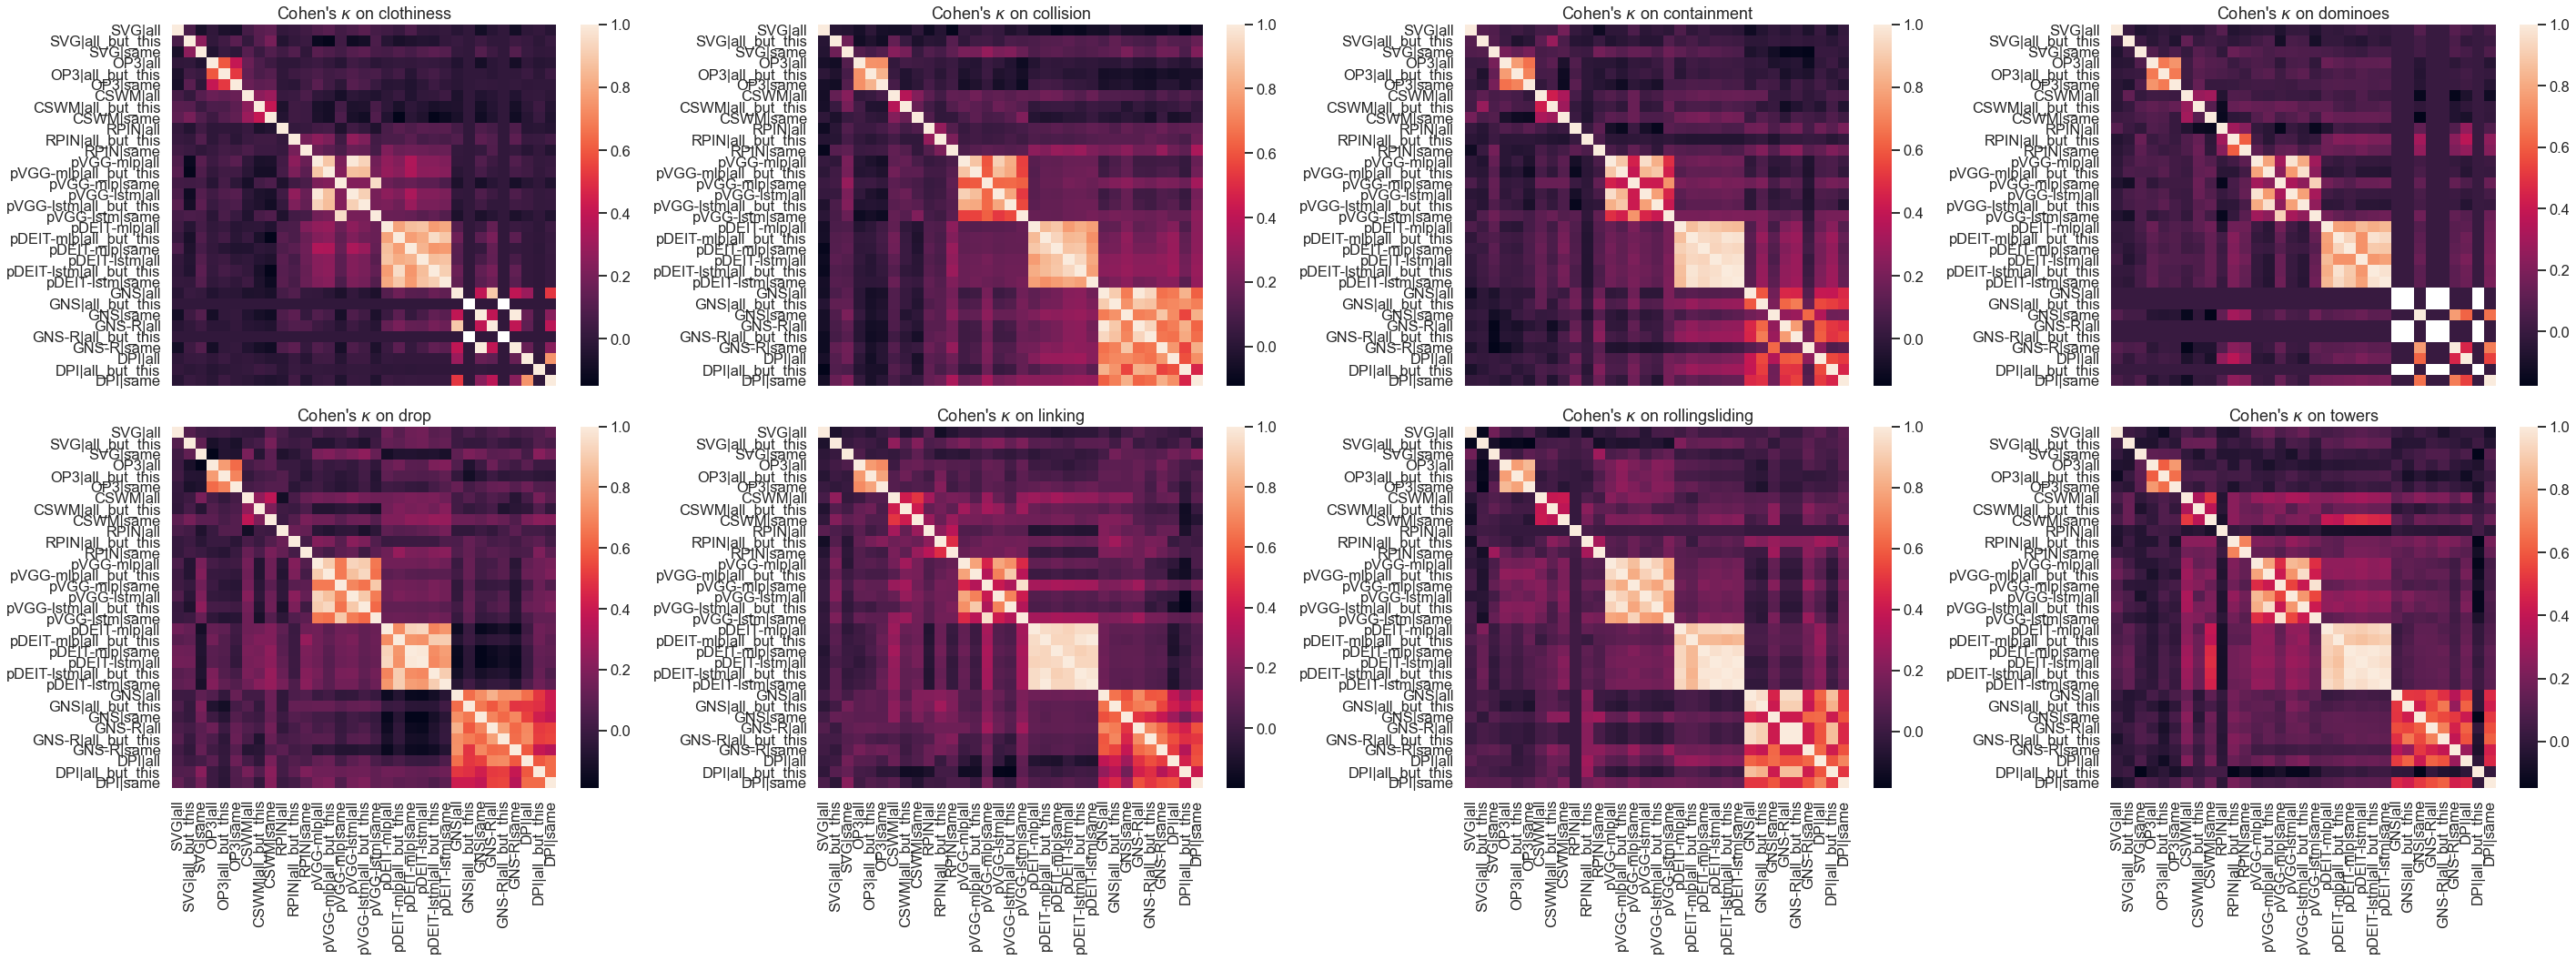

In [92]:
figure, axes = plt.subplots(2, 4, sharex=True, figsize=(20*2,7.5*2)) 
for i,(scenario, Cohens_k_df) in enumerate(Cohens_k_dfs.items()):
    ax = axes.flatten()[i]
    sns.heatmap(
        Cohens_k_df.fillna(0,inplace=False), #crashes if na
        ax = ax,
        mask=np.array(Cohens_k_df.isnull()), #hide na
        xticklabels=Cohens_k_df.columns,
        yticklabels=Cohens_k_df.index,
    )
    ax.set_title("Cohen's $\kappa$ on {}".format(scenario))
plt.tight_layout()
plt.show()

### Correlation

In [ ]:
Corr_dfs = {}
for scenario in SCENARIOS:
    Corr_df = pd.DataFrame(index = MODELS,columns = MODELS)
    _df = df[df['Readout Test Data'] == scenario] #get scenario
    for model1,model2 in tqdm([(m1,m2) for m1 in MODELS for m2 in MODELS]):
        resp1,resp2 = get_response_vectors(_df,model1,model2) 
        if len(resp1)>0:
            measure,p = scipy.stats.pearsonr(resp1,resp2)
            Corr_df.loc[model1,model2] = measure
    Corr_dfs[scenario] = Corr_df #save scenario results

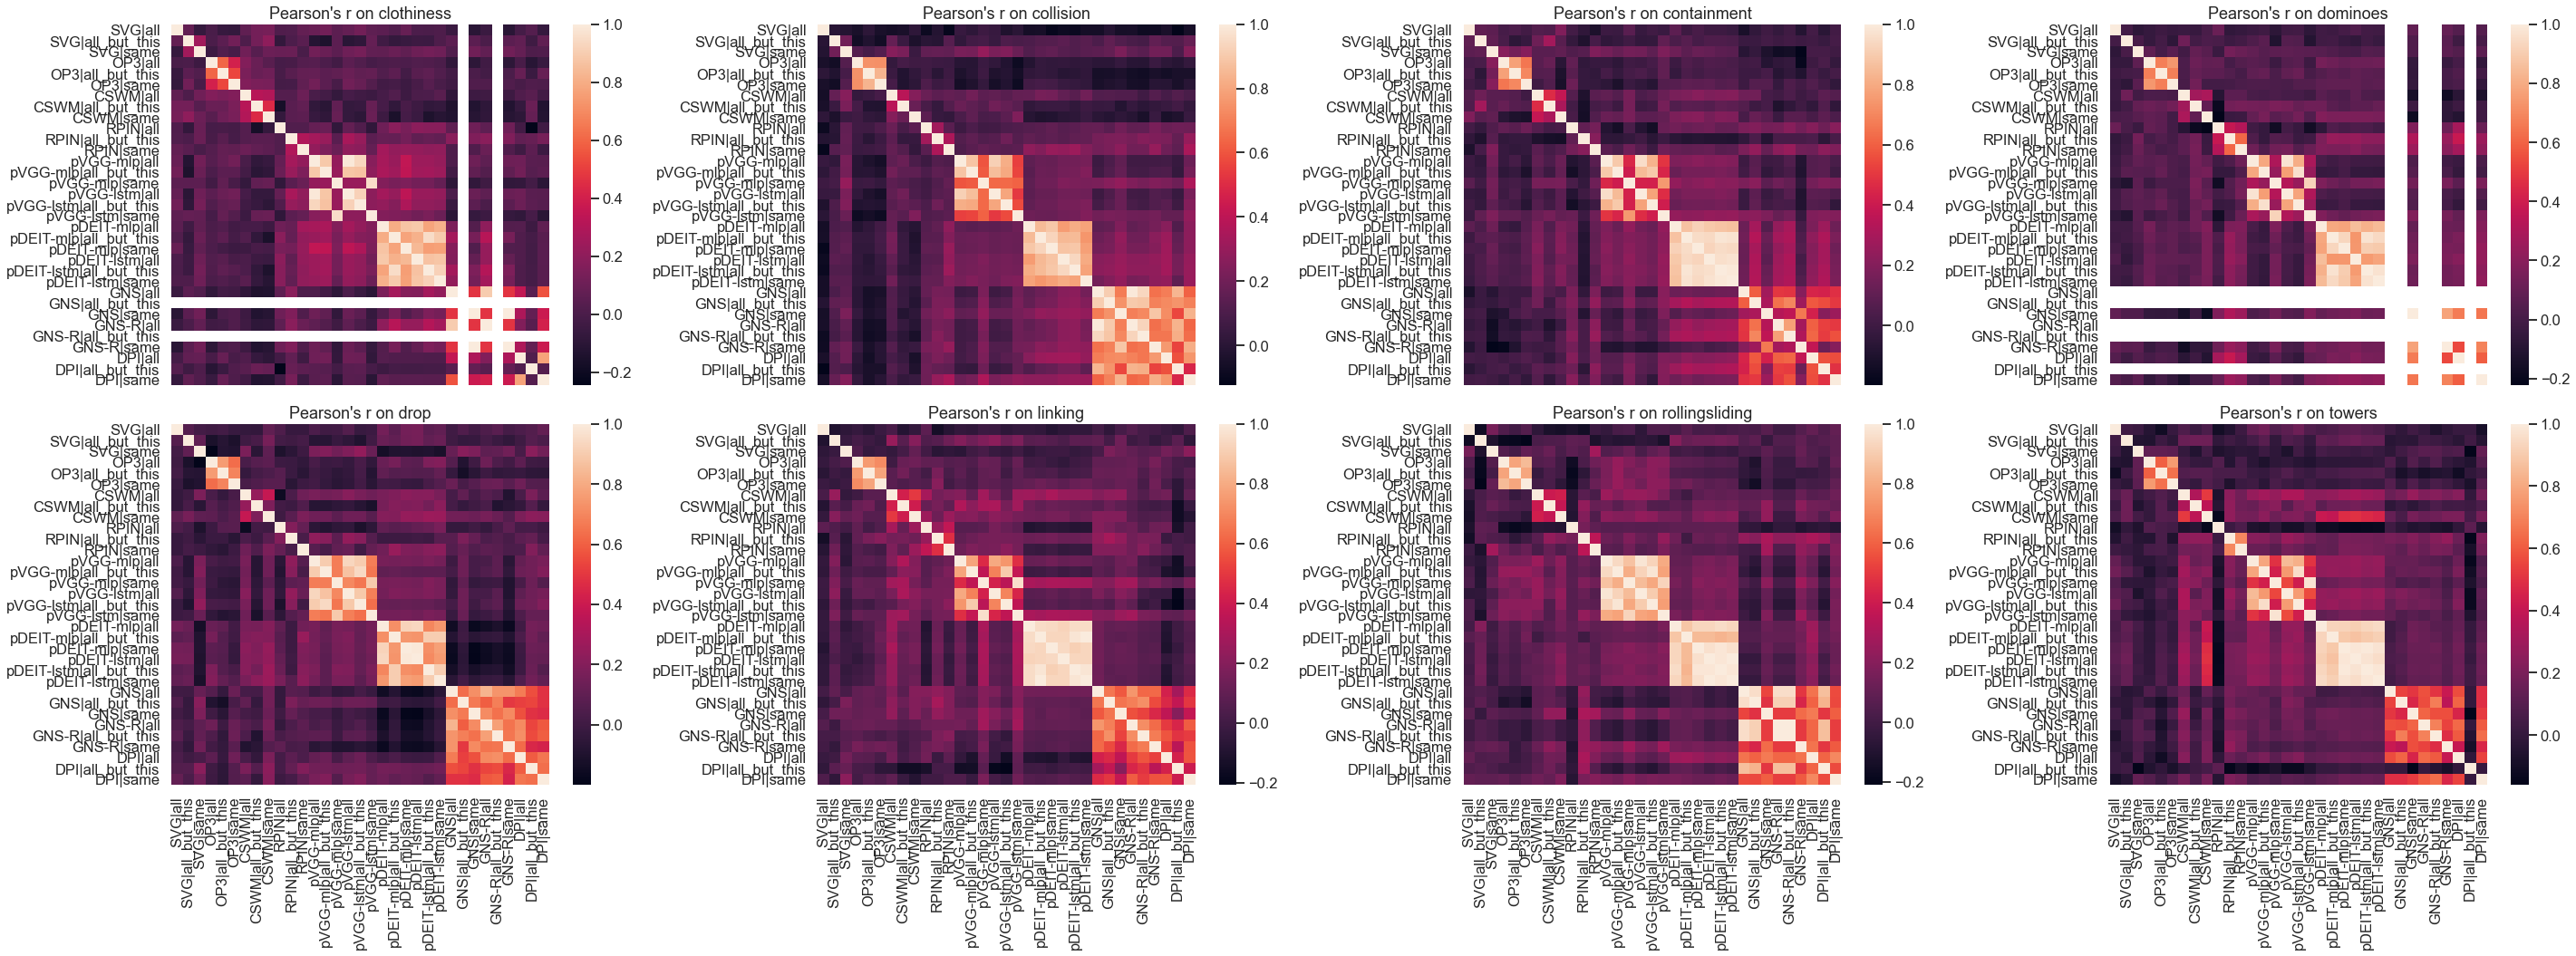

In [94]:
figure, axes = plt.subplots(2, 4, sharex=True, figsize=(20*2,7.5*2)) 
for i,(scenario, Corr_df) in enumerate(Corr_dfs.items()):
    ax = axes.flatten()[i]
    sns.heatmap(
        Corr_df.fillna(0,inplace=False), #crashes if na
        ax = ax,
        mask=np.array(Corr_df.isnull()), #hide na
        xticklabels=Corr_df.columns,
        yticklabels=Corr_df.index,
    )
    ax.set_title("Pearson's r on {}".format(scenario))
plt.tight_layout()
plt.show()